In [121]:
import numpy as np
import random
from matplotlib import pyplot as plt
import math

#val acc more than train sometimes
#which nonlinearities to try, sigmoid also? currently relu is used
#plot loss
#hyperparam search
#finite diff grads
#the three init schemes compare - (no learning for zero init, gaussian and glroot seem similar)

def sigmoid(x):
  
    return 1 / (1 + np.exp(-x))

class NN(object):
    
    def __init__(self,hidden_dims=(200,200),n_hidden=2,mode='train',datapath=None,model_path=None,init = '', lr =1e-3):
        self.init_method = ''
        
        self.h0 = 784     # +1 for bias
        self.h1 = hidden_dims[0]
        self.h2 = hidden_dims[1]
        self.h3 = 10
        
        self.layer_sizes = [self.h0, self.h1, self.h2, self.h3]
        self.network = [] # list of weights
        self.num_hlayers = 2
        self.num_classes = 10
        
        self.epochs = 10
        self.lr = lr
        self.batch_size = 10
        self.init_method = init
        self.history = []
        self.dataprep()
        self.initialize_weights()
        loss, val_loss = self.train()
        self.plot(loss, val_loss)
        
        self.test()
        

    def dataprep(self):

        data = np.load('mnist.pkl', encoding='latin1')
        
        train_set, val_set, test_set = data
        
        self.train_set, self.train_labels = train_set
        self.val_set, self.val_labels = val_set
        self.test_set, self.test_labels = test_set
        
        self.train_size = self.train_set.shape[0]
        self.val_size = self.val_set.shape[0]
        self.test_size = self.test_set.shape[0]

  
        print(self.train_set.shape)
        print(self.val_set.shape)
        print(self.test_set.shape)
    
    def plot(self, loss, val_loss):
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('model accuracy')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
      
    def train(self):    
        m = self.train_size
        val_samples = self.val_size

        loss_history = np.zeros(self.epochs)
        val_loss_history = np.zeros(self.epochs)
        
       
        n_batches = int(m/self.batch_size)
        batch_size = self.batch_size

        
        
        print('zero shot validation')
        val_batches = 0
        val_loss= 0.0
        val_accuracy = 0
        for i in range(0,val_samples-batch_size+1,batch_size):
            X_i_val = self.val_set[i:i+batch_size]
            y_i_val = self.val_labels[i:i+batch_size]
            outputs_val = self.forward(X_i_val)
            
            labels = np.argmax(outputs_val[-1], axis=1)
            val_accuracy += (y_i_val == labels).sum()           
            
            one_hot = np.zeros((self.batch_size, self.num_classes))
            one_hot[np.arange(self.batch_size), y_i_val] = 1
            loss_val_batch = self.loss(outputs_val[-1], one_hot)
            val_loss += loss_val_batch
            val_batches +=1
        val_accuracy = val_accuracy/(1.0*val_batches*self.batch_size)
        val_loss = val_loss/(1.0*val_batches*self.batch_size)
        print('val accuracy : '+str(val_accuracy))

        print('val loss : ' + str(val_loss))
            
            
        
        for it in range(self.epochs):
            print('epoch : '+str(it))
            loss = 0.0
            val_loss= 0.0
            train_accuracy = 0
            indices = np.random.permutation(m)
            train_set = self.train_set[indices]
            train_labels = self.train_labels[indices]


            train_batches = 0 
            for i in range(0,m-batch_size+1,batch_size):
                X_i = train_set[i:i+batch_size]
                y_i = train_labels[i:i+batch_size]
                outputs = self.forward(X_i)
                loss_batch, accuracy_batch = self.backward(outputs, y_i)
                loss += loss_batch
                train_accuracy += accuracy_batch
                train_batches +=1
            loss = loss/(1.0*train_batches*self.batch_size)
            train_accuracy = train_accuracy/(1.0*train_batches*self.batch_size)
           

            print('train loss : ' + str(loss))      
            print('train accuracy : '+ str(train_accuracy))

            print('validation')
            val_batches = 0
            val_accuracy = 0
            for i in range(0,val_samples-batch_size+1,batch_size):
           
        
                X_i_val = self.val_set[i:i+batch_size]
                y_i_val = self.val_labels[i:i+batch_size]
                outputs_val = self.forward(X_i_val)
                labels = np.argmax(outputs_val[-1], axis=1)
                val_accuracy += (y_i_val == labels).sum()  
            
                one_hot = np.zeros((self.batch_size, self.num_classes))
                one_hot[np.arange(self.batch_size), y_i_val] = 1
                                
                loss_val_batch = self.loss(outputs_val[-1], one_hot)
                val_loss += loss_val_batch
                val_batches +=1
            val_loss = val_loss/(1.0*val_batches*self.batch_size)
            val_accuracy = val_accuracy/(1.0*val_batches*self.batch_size)
            print('val accuracy : '+str(val_accuracy))
            print('val loss : ' + str(val_loss))

            self.history.append([train_accuracy, val_accuracy])
            val_loss_history[it]  = val_loss
            loss_history[it]  = loss

        return loss_history, val_loss_history

    def initialize_weights(self):
        if(self.init_method=='zeros'):
            for i in range(len(self.layer_sizes)-1):
                layer_weights = np.zeros((self.layer_sizes[i]+1,self.layer_sizes[i+1]))
                layer_weights[-1,:] = 0
                print(layer_weights.shape)
                self.network.append(layer_weights) 
        elif(self.init_method=='glorot'):

            for i in range(len(self.layer_sizes)-1):
                d = math.sqrt(6.0/(self.layer_sizes[i]+self.layer_sizes[i+1]))      
                layer_weights = np.random.uniform(-d,d,(self.layer_sizes[i]+1,self.layer_sizes[i+1]))
                layer_weights[-1,:] = 0
                print(layer_weights.shape)
                self.network.append(layer_weights)    
                
        else:
            for i in range(len(self.layer_sizes)-1):
                layer_weights = np.random.normal(0,1,(self.layer_sizes[i]+1,self.layer_sizes[i+1]))
#                 layer_weights[-1,:] = 0  ##baises
                print(layer_weights.shape)
                self.network.append(layer_weights) 
#         print('shapes of layers')
#         for net_wt in self.network:
#             print(net_wt.shape)
  
    def activation(self,inputs, layer_no):
        inputs = np.hstack((inputs, np.ones((inputs.shape[0],1)) ))
        activation = np.dot(inputs, self.network[layer_no])     
        return activation
    
    def softmax(self,inputs): 
        # Result of softmax are invariant even if we add/subtract a constant.  
     
        ex = np.exp(inputs - np.max(inputs, axis=1,  keepdims=True))  # Subtract such that the maximum value is one.

        return ex / ex.sum(axis=1,  keepdims=True)  

    def forward(self,inputs):

        #we are always appending inputs before doing relu to the cache

        outputs = []
        outputs.append(inputs)

        for layer_no in range(len(self.network)-1):        
            inputs = self.activation(inputs, layer_no)

            outputs.append(inputs)
            np.maximum(inputs,0,inputs)              #relu     
       
        inputs = self.activation(inputs, len(self.network)-1 )
        

        inputs = self.softmax(inputs)

        outputs.append(inputs)

        return outputs 
    
    def relu(self, inputs):
        outputs = np.maximum(inputs,0)
        return outputs
    
    def backward(self,cache,labels):
        #cache should have
        #layer0_input    x0 
        #layer1_output   x1=(w0(x0)+bo) (relu-ed in network but not here)
        #layer2_output   x2=(w1(x1)+b1) (relu-ed in network but not here)
        #network_outputs x3=softmax+crossentropy(w2(x2)+b2)    

        predictions = cache[-1]
        one_hot = np.zeros((self.batch_size, self.num_classes))
        one_hot[np.arange(self.batch_size), labels] = 1
        loss_batch = self.loss(predictions, one_hot)

        pred_labels = np.argmax(predictions, axis=1)
        accuracy_batch = (labels == pred_labels).sum()        

        #compute gradients for weights and biases - divide by num_samples?
        gradients = []
        grad =  (one_hot - predictions )  /(1.0*self.batch_size)   


        #wrt w3 b3
        temp = np.hstack((cache[-2], np.ones((predictions.shape[0],1)) ))


        gradients.append(np.dot(np.transpose(self.relu(temp)),grad)) #weights        
        grad = np.dot(grad, np.transpose(self.network[2][:-1,:]))   
        grad[cache[-2]<0] = 0 

        #wrt w2 b2
        temp = np.hstack((cache[-3], np.ones((predictions.shape[0],1)) ))
        gradients.append(np.dot(np.transpose(self.relu(temp)),grad)) #weights    
        grad = np.dot(grad, np.transpose(self.network[1][:-1,:]))

        grad[cache[-3]<0] = 0 

        #wrt w1 b1        
        temp = np.hstack((cache[-4], np.ones((predictions.shape[0],1)) )) 
        gradients.append(np.dot(np.transpose(temp),grad)) #weights

        self.update(gradients)

        return loss_batch, accuracy_batch

    def reluDerivative(x): 
        x[x<=0] = 0
        x[x>0] = 1
        return x
        
        
    def loss(self,predictions,targets): #cross entropy

        epsilon = 1e-12
#         predictions = np.clip(predictions, epsilon, 1. - epsilon)

        ce = -np.sum(np.multiply(targets,np.log(predictions+1e-9)), axis=1)/(targets.shape[0]*1.0)

        ce = np.sum(ce)
        return ce
    
    def update(self,grads):
        length_net = len(self.network)
        assert(len(grads)==length_net)

        i=0
        for layer_no in range(length_net):
            self.network[layer_no] += self.lr * grads[length_net-1-i]             
            i += 1
            
    def test(self):
        m = self.test_size
        batch_size = self.batch_size

        for it in range(self.epochs):
            loss =0.0
            for i in range(0,m,batch_size):
                X_i = self.test_set[i:i+batch_size]
                y_i = self.test_labels[i:i+batch_size]
                outputs = self.forward(X_i)  
                one_hot = np.zeros((self.batch_size, self.num_classes))
                one_hot[np.arange(self.batch_size), y_i] = 1                
                loss += self.loss(outputs[-1], one_hot)

        return loss
    
    def finite_diff(self,i, inputs, targets):
        epsilon = 1/(10**i)
      
        length_net = len(self.network)
   
        finite_diff = []

        for layer_no in range(1):
            layer_grad = []

            x,y = self.network[layer_no].shape
            for i in range(x-1):
                for j in range(y-1):
                   

                    self.network[layer_no][i,j] = self.network[layer_no][i,j] + epsilon
                    
                    output_p =self.loss(self.forward(inputs)[-1], targets)
                    self.network[layer_no][i,j] = self.network[layer_no][i,j] - 2*epsilon
                
                    output_n = self.loss(self.forward(inputs)[-1], targets)
                    self.network[layer_no][i,j] = self.network[layer_no][i,j] + epsilon
                    
           
                 
                    grad = (output_p - output_n)/(2*epsilon)
                  
                    layer_grad.append(grad)
            finite_diff.extend(np.array(layer_grad))
        return finite_diff
      

   


(50000, 784)
(10000, 784)
(10000, 784)
(785, 200)
(201, 200)
(201, 10)
zero shot validation
val accuracy : 0.0891
val loss : 1.881982720761767
epoch : 0
train loss : 0.7120246839284475
train accuracy : 0.64988
validation
val accuracy : 0.7872
val loss : 0.4297596638847929
epoch : 1
train loss : 0.40290043728154223
train accuracy : 0.7995
validation
val accuracy : 0.8323
val loss : 0.33677591217928343
epoch : 2
train loss : 0.34017770699774447
train accuracy : 0.8301
validation
val accuracy : 0.8414
val loss : 0.3169004481868412
epoch : 3
train loss : 0.31222499112488755
train accuracy : 0.84368
validation
val accuracy : 0.8523
val loss : 0.29713659935603387
epoch : 4
train loss : 0.29634020146382944
train accuracy : 0.85152
validation
val accuracy : 0.8594
val loss : 0.2824911490258578
epoch : 5
train loss : 0.2791469007538466
train accuracy : 0.85948
validation
val accuracy : 0.8621
val loss : 0.27483301411552463
epoch : 6
train loss : 0.2677573841980519
train accuracy : 0.86476
valid

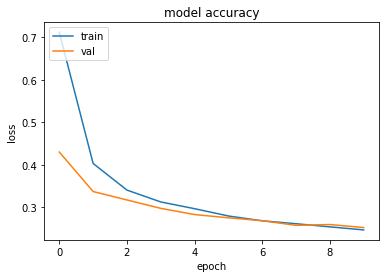

In [120]:
nn_normal = NN()

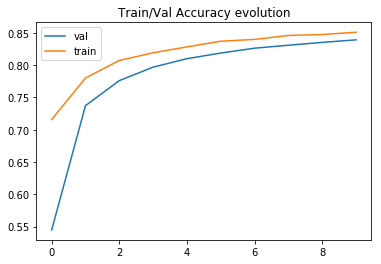

In [118]:
history = nn_normal.history
plot(history)

(50000, 784)
(10000, 784)
(10000, 784)
(785, 200)
(201, 200)
(201, 10)
zero shot validation
val accuracy : 0.1004
val loss : 1.8596719556140198
epoch : 0
train loss : 0.35787098770757353
train accuracy : 0.82178
validation
val accuracy : 0.8783
val loss : 0.2411996604497257
epoch : 1
train loss : 0.2477765457324661
train accuracy : 0.87328
validation
val accuracy : 0.8928
val loss : 0.20775415574160216
epoch : 2
train loss : 0.21793451557062538
train accuracy : 0.8874
validation
val accuracy : 0.9048
val loss : 0.1809468400681943
epoch : 3
train loss : 0.20059118526759384
train accuracy : 0.8943
validation
val accuracy : 0.9056
val loss : 0.17647750768440712
epoch : 4
train loss : 0.18703903647970405
train accuracy : 0.90068
validation
val accuracy : 0.9088
val loss : 0.16747801747107738
epoch : 5
train loss : 0.17902562107584644
train accuracy : 0.90218
validation
val accuracy : 0.908
val loss : 0.1691740449190778
epoch : 6
train loss : 0.1690440545983139
train accuracy : 0.90654
vali

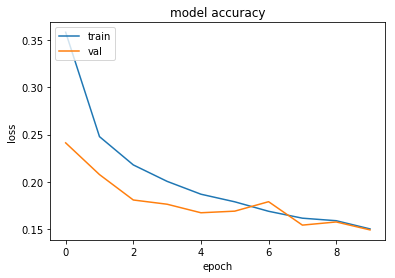

In [122]:
nn_norm_3 = NN()

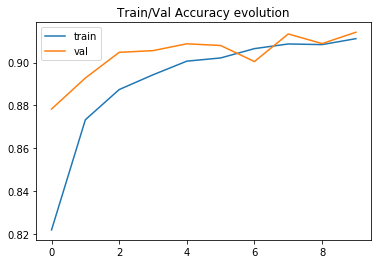

In [125]:
history = nn_norm_3.history
plot(history)

(50000, 784)
(10000, 784)
(10000, 784)
(785, 612)
(613, 612)
(613, 10)
zero shot validation
val accuracy : 0.0991
val loss : 0.2302585082994031
epoch : 0
train loss : 0.23025124115589668
train accuracy : 0.11262
validation
val accuracy : 0.1064
val loss : 0.2302483473626017
epoch : 1
train loss : 0.23023678507071607
train accuracy : 0.11356
validation
val accuracy : 0.1064
val loss : 0.23023937066256375
epoch : 2
train loss : 0.23022371751147752
train accuracy : 0.11356
validation
val accuracy : 0.1064
val loss : 0.2302314730145764
epoch : 3
train loss : 0.2302119047170745
train accuracy : 0.11356
validation
val accuracy : 0.1064
val loss : 0.23022454808125034
epoch : 4
train loss : 0.23020121909441185
train accuracy : 0.11356
validation
val accuracy : 0.1064
val loss : 0.2302184821070784
epoch : 5
train loss : 0.23019157719056585
train accuracy : 0.11356
validation
val accuracy : 0.1064
val loss : 0.23021319782491378
epoch : 6
train loss : 0.23018286558524628
train accuracy : 0.11356


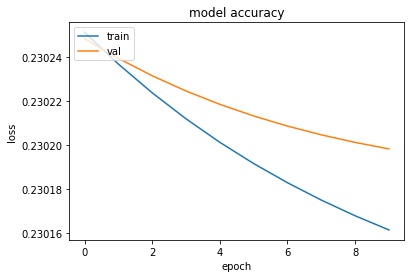

In [7]:
nn_zer = NN(init = 'zeros')

(50000, 784)
(10000, 784)
(10000, 784)
(785, 612)
(613, 612)
(613, 10)
zero shot validation
val accuracy : 0.1049
val loss : 0.2332019469187495
epoch : 0
train loss : 0.21010727151006028
train accuracy : 0.40276
validation
val accuracy : 0.6594
val loss : 0.18940079697842988
epoch : 1
train loss : 0.1726558098681471
train accuracy : 0.69764
validation
val accuracy : 0.7566
val loss : 0.1539279907144527
epoch : 2
train loss : 0.14061641913422349
train accuracy : 0.75654
validation
val accuracy : 0.7932
val loss : 0.12396896806303682
epoch : 3
train loss : 0.11511779890346775
train accuracy : 0.78484
validation
val accuracy : 0.8208
val loss : 0.10141140149637212
epoch : 4
train loss : 0.09662631932723133
train accuracy : 0.80774
validation
val accuracy : 0.8359
val loss : 0.08548239180591985
epoch : 5
train loss : 0.08361612607235112
train accuracy : 0.82366
validation
val accuracy : 0.8492
val loss : 0.07429608223663882
epoch : 6
train loss : 0.07434117888518763
train accuracy : 0.8351

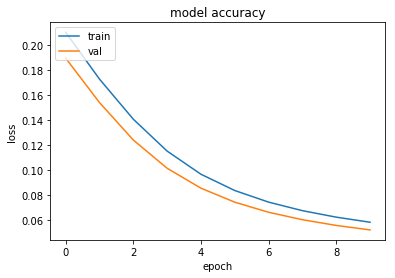

In [8]:
nn_glorot = NN(init = 'glorot')

In [3]:

train, val, test = data
train_set, train_labels = train


In [61]:
nn_normal.forward(train_set[30:31])[-1]

/Users/rimassouel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:198: RuntimeWarning: invalid value encountered in true_divide


array([[ 0.,  0.,  0.,  0., nan, nan, nan,  0.,  0., nan]])

In [19]:
label = train_labels[30:31]
one_hot = np.zeros((1,10))
n
finit_norm = nn_norm.finite_diff(1,train_set[30:31],one_hot)

In [ ]:
np.max(finit_normt_norm)

# Part 2 - CNN

In [10]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as data_utils


In [31]:
def loader(data, batch_size = 32) : 
   
    train, val, test = data
    train, train_lab = train
    val, val_lab = val
    test, test_lab = test
    
    train_data, val_data, test_data  = torch.from_numpy(train).view(-1, 1,28,28), torch.from_numpy(val).view(-1, 1,28,28), torch.from_numpy(test).view(-1, 1,28,28)
    
    train_target, val_target, test_target  = torch.from_numpy(train_lab),  torch.from_numpy(val_lab), torch.from_numpy(test_lab)



    train_set = data_utils.TensorDataset(train_data, train_target)
    val_set = data_utils.TensorDataset(val_data, val_target)
    test_set = data_utils.TensorDataset(test_data, test_target)
    
    train_loader = data_utils.DataLoader(train_set, batch_size=batch_size, shuffle = True)
    val_loader = data_utils.DataLoader(val_set, batch_size=batch_size, shuffle = False)
    test_loader = data_utils.DataLoader(test_set, batch_size=batch_size, shuffle = False)
    
    return train_loader, val_loader, test_loader



In [32]:
data = np.load('mnist.pkl', encoding ='latin1')
train_loader, val_loader, test_loader = loader(data)

In [99]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
      
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
       
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
       
        self.fc = nn.Linear(7*7*32, num_classes)
      
        
        self.history = []
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
       
     
        out = out.reshape(out.size(0), -1)
        
        out = self.fc(out)
       
       
        return out

class Trainer(object):
    def __init__(self, train_loader,val_loader, epochs = 10, lr_init = 1e-3, batch_size = 32, num_classes = 10):
        self.epochs = epochs
        self.lr = lr_init
        self.loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
       
        self.model = CNN(num_classes)
        self.history = []
    
   
    
    def train(self,num_classes):
       
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            for i, (images, labels) in enumerate(self.loader):
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                if (i+1) % 500 == 0:
                    print ( 'Loss: {:.4f}' 
                           .format(loss.item()))
            self.val()
    
    def val(self) :
        
        correct = 0
        total = 0
        for images, labels in self.val_loader:
            outputs =self.model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        

        print('Val Accuracy of the model : {} %'.format(100 * correct / total))
        
        val_acc = 100 * correct / total
        
        total = 0 
        correct = 0
        
        for images, labels in self.loader:
            outputs =self.model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        print('Train Accuracy of the model : {} %'.format(100 * correct / total))
        
        train_acc = 100 * correct / total
        
        self.history.append([train_acc, val_acc])
        




### Training with lr = 1e-3

In [103]:
trainer = Trainer(train_loader=train_loader, val_loader=val_loader)

In [104]:
trainer.train(10)

Loss: 2.2385
Loss: 2.1332
Loss: 1.5196
Val Accuracy of the model : 74.42 %
Train Accuracy of the model : 72.384 %
Loss: 0.8402
Loss: 0.8174
Loss: 0.3159
Val Accuracy of the model : 88.05 %
Train Accuracy of the model : 86.65 %
Loss: 0.6537
Loss: 0.5298
Loss: 0.1833
Val Accuracy of the model : 90.69 %
Train Accuracy of the model : 89.468 %
Loss: 0.2659
Loss: 0.6090
Loss: 0.3970
Val Accuracy of the model : 91.83 %
Train Accuracy of the model : 90.968 %
Loss: 0.6521
Loss: 0.4905
Loss: 0.0506
Val Accuracy of the model : 92.63 %
Train Accuracy of the model : 91.786 %
Loss: 0.6906
Loss: 0.1469
Loss: 0.3711
Val Accuracy of the model : 92.89 %
Train Accuracy of the model : 92.144 %
Loss: 0.2427
Loss: 0.4244
Loss: 0.2388
Val Accuracy of the model : 93.92 %
Train Accuracy of the model : 93.14 %
Loss: 0.2502
Loss: 0.3222
Loss: 0.0553
Val Accuracy of the model : 94.27 %
Train Accuracy of the model : 93.576 %
Loss: 0.3467
Loss: 0.2586
Loss: 0.0734
Val Accuracy of the model : 94.79 %
Train Accuracy 

In [105]:
history = trainer.history

In [124]:
def plot(history):
    history = np.array(history)
    plt.plot(history[:,0], label ='train')
    plt.plot(history[:,1], label = 'val')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Train/Val Accuracy evolution')

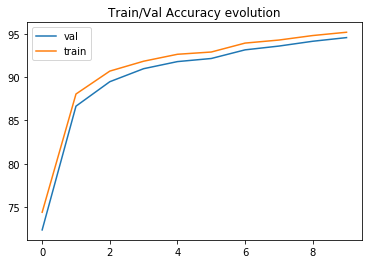

In [109]:
plot(history)